In [1]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')

## Goal
In this statistical analysis, we perform hypothesis tests to answer the following questions:  
##### Question 1
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?  
##### Question 2
Is there a statistically significant difference in the level(s) of discount offered by UK employees and USA employees?  
Does the level(s) of discount offered by US employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?  
Does the level(s) of discount offered by UK employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?  
##### Question 3
Does the age of the employee have a statistically significant effect on number of orders processed?  
Does having manager in your title have a statistically significant effect on number of orders processed?  
Does the age of the employee have a statistically significant effect on the quantity of a product in an order?  
Does having manager in your title have a statistically significant effect on quantity ordered?  
##### Question 4
For each category type of product, does the season in which the order was placed have a statistically significant effect on the quantity of a product in an order?  
##### Question 5
Does shipping company used have a statistically significant effect on the freight cost of shipping?  
##### Question 6
Does category of product have a statistically signficiant effect on processing time? If so, which ones?  
Does having a discount on the order have a statistically significant effect on processing time?  
Does size of order have a statistically signficant effect on processing time?  
Does shipping company have a statistically significant effect on processing time?

## Question 1
### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

$H_0$: there is no significant difference in quantity ordered due to discount

$H_\alpha$: there is a significant difference in order quantity due to discount

In [3]:
x = """SELECT Quantity, Discount
       FROM OrderDetail
       ;"""
q1A = pd.read_sql_query(x, conn)
q1A.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [4]:
for ind, x in enumerate(q1A.Discount):
    if x == 0:
        q1A.loc[ind, 'is_Discount'] = False
    else:
        q1A.loc[ind, 'is_Discount'] = True
q1A.sample(20)

,Quantity,Discount,is_Discount
0,12,0.00,False
501,15,0.20,True
1253,45,0.00,False
1416,30,0.00,False
1238,32,0.05,True
1911,60,0.00,False
999,10,0.00,False
636,24,0.25,True
1332,5,0.00,False
167,3,0.00,False


In [5]:
f = 'Quantity ~ C(is_Discount)'
lm = ols(f, q1A).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq      df          F        PR(>F)
C(is_Discount)   14903.513199     1.0  41.971781  1.144092e-10
Residual        764496.122996  2153.0        NaN           NaN


In [6]:
q1A.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [7]:
q1B = q1A.loc[q1A['Discount'] != 0]
q1B = q1B.reset_index(drop=True)

In [8]:
newc = ['Discountlow', 'Discount10', 'Discount15', 'Discount20', 'Discount25']
for x in newc:
    q1B[x] = False

for idx, x in enumerate(q1B.Discount):
    if 0 < x <= 0.06:
        q1B.loc[idx, 'Discountlow'] = True
    elif x == 0.10:
        q1B.loc[idx, 'Discount10'] = True
    elif x == 0.15:
        q1B.loc[idx, 'Discount15'] = True
    elif x == 0.20:
        q1B.loc[idx, 'Discount20'] = True
    elif x == 0.25:
        q1B.loc[idx, 'Discount25'] = True
q1B.sample()
display(q1B.Quantity.value_counts())
q1B.Quantity.describe()

20     98
30     72
15     69
40     53
10     51
25     36
50     35
12     35
35     29
60     28
6      25
18     23
24     22
2      22
8      21
21     20
70     18
4      16
5      14
16     14
36     12
3      12
42     11
28     11
80     10
14      8
9       8
7       6
100     6
55      5
65      5
45      5
120     5
1       4
49      4
90      3
11      2
32      2
13      2
27      2
44      2
48      2
56      2
77      2
84      2
33      1
54      1
66      1
130     1
Name: Quantity, dtype: int64

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

In [9]:
z = q1B['Quantity'].value_counts()
z1 = z.to_dict()
q1B['Count'] = q1B['Quantity'].map(z1)
for idx, x in enumerate(q1B.Count):
    if x < 4:
        if q1B.Quantity[idx] == 1:
            pass
        else:
            q1B.drop(index = idx, axis = 0, inplace=True)
q1B = q1B.reset_index(drop=True)

In [10]:
q1B.head()

,Quantity,Discount,is_Discount,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,35,0.15,True,False,False,True,False,False,29
1,15,0.15,True,False,False,True,False,False,69
2,6,0.05,True,True,False,False,False,False,25
3,15,0.05,True,True,False,False,False,False,69
4,40,0.05,True,True,False,False,False,False,53


### At what level(s) of discount is there a statistically significant difference in quantity ordered?

$H_0$ (for each level): there is no significant difference in quantity ordered due to that specific discount level

$H_\alpha$ (for each level): there is a significant difference in order quantity due to that specific discount level

In [11]:
f = 'Quantity ~ C(Discountlow) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'
lm = ols(f, q1B).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Discountlow),3859.920738,1.0,9.776806,0.001831
C(Discount10),1048.339618,1.0,2.655343,0.103592
C(Discount15),4808.926912,1.0,12.180547,0.000509
C(Discount20),3710.582189,1.0,9.398546,0.002244
C(Discount25),7210.642740,1.0,18.263861,0.000022
Residual,319001.510225,808.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
0.0,0.05,5.207,1.0635,9.3506,True
0.0,0.1,3.5217,-0.8257,7.8692,False
0.0,0.15,6.6669,2.1279,11.2059,True
0.0,0.2,5.3096,0.8212,9.7979,True
0.0,0.25,6.525,1.9467,11.1033,True
0.05,0.1,-1.6853,-7.3138,3.9432,False
0.05,0.15,1.4599,-4.3179,7.2377,False
0.05,0.2,0.1026,-5.6355,5.8406,False
0.05,0.25,1.318,-4.4907,7.1267,False
0.1,0.15,3.1452,-2.7805,9.0709,False


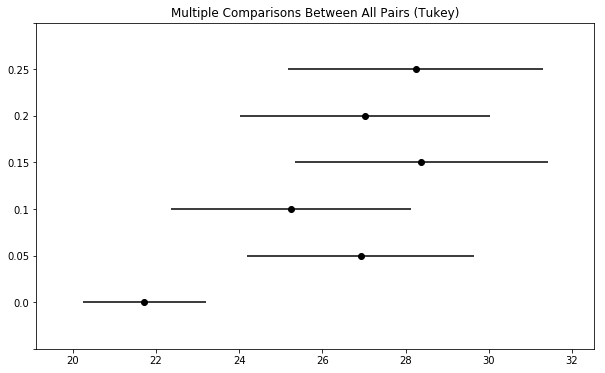

In [12]:
for idx, x in enumerate(q1A.Discount):
    if 0.00 < x <= 0.06:
        q1A.loc[idx, 'Discount'] = 0.05
    else:
        pass
tukey_results = pairwise_tukeyhsd(q1A['Quantity'], q1A['Discount'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

## Question 2
### Is there a statistically significant difference in the level(s) of discount offered by UK employees and USA employees?

$H_0$: there is no significant difference in level(s) of discount offered by the two countries

$H_\alpha$: there is a significant difference in level(s) of discount offered by the two countries

In [13]:
x = """SELECT od.Quantity, od.Discount, e.Country
       FROM OrderDetail AS od
       JOIN [Order] ON od.OrderId = [Order].Id
       JOIN Employee AS e ON [Order].EmployeeId = e.Id
       ;"""
q2 = pd.read_sql_query(x, conn)
q2.head()

,Quantity,Discount,Country
0,12,0.0,UK
1,10,0.0,UK
2,5,0.0,UK
3,9,0.0,UK
4,40,0.0,UK


In [14]:
f = 'Discount ~ C(Country)'
lm = ols(f, q2).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Country),0.067081,1.0,9.671415,0.001896
Residual,14.933259,2153.0,NaN,NaN


In [15]:
q2A = q2.drop('Quantity', axis = 1).pivot_table(index='Country', columns='Discount', aggfunc=len, fill_value=0, margins=True)
q2A

Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25,All
Country,,,,,,,,,,,,
UK,309,0,0,0,0,55,0,60,53,45,46,568
USA,1008,1,2,3,1,130,1,113,104,116,108,1587
All,1317,1,2,3,1,185,1,173,157,161,154,2155


In [16]:
for x in q2A.columns:
    q2A.loc['UK', x] = round((float(q2A[x]['UK'])/float(q2A['All']['UK'])*100), 2)
    q2A.loc['USA', x] = round((float(q2A[x]['USA'])/float(q2A['All']['USA'])*100), 2)
q2A.drop(['All'], axis = 1, inplace = True)
q2A.drop(['All'], axis = 0, inplace = True)
q2A

Discount,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
Country,,,,,,,,,,,
UK,54.40,0.00,0.00,0.00,0.00,9.68,0.00,10.56,9.33,7.92,8.10
USA,63.52,0.06,0.13,0.19,0.06,8.19,0.06,7.12,6.55,7.31,6.81


In [17]:
tukey_results = pairwise_tukeyhsd(q2['Discount'], q2['Country'])
display(tukey_results.summary())

group1,group2,meandiff,lower,upper,reject
UK,USA,-0.0127,-0.0206,-0.0047,True


### Does the level(s) of discount offered by US employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?

$H_0$ (for each level): there is no significant difference in quantity ordered due to that specific discount level

$H_\alpha$ (for each level): there is a significant difference in order quantity due to that specific discount level

In [18]:
for x in newc:
    q2[x] = False

for idx, x in enumerate(q2.Discount):
    if 0 < x <= 0.06:
        q2.loc[idx, 'Discountlow'] = True
    elif x == 0.10:
        q2.loc[idx, 'Discount10'] = True
    elif x == 0.15:
        q2.loc[idx, 'Discount15'] = True
    elif x == 0.20:
        q2.loc[idx, 'Discount20'] = True
    elif x == 0.25:
        q2.loc[idx, 'Discount25'] = True
q2.sample(10)

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25
1232,12,0.25,UK,False,False,False,False,True
2125,30,0.15,USA,False,False,True,False,False
1983,15,0.00,UK,False,False,False,False,False
1985,25,0.00,UK,False,False,False,False,False
1474,40,0.10,UK,False,True,False,False,False
684,36,0.00,UK,False,False,False,False,False
467,2,0.00,USA,False,False,False,False,False
289,30,0.20,USA,False,False,False,True,False
1367,40,0.00,USA,False,False,False,False,False
696,39,0.00,USA,False,False,False,False,False


In [19]:
q2B = q2.loc[q2['Discount'] != 0]
q2B = q2B.reset_index(drop=True)
q2B.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25
0,35,0.15,USA,False,False,True,False,False
1,15,0.15,USA,False,False,True,False,False
2,6,0.05,USA,True,False,False,False,False
3,15,0.05,USA,True,False,False,False,False
4,40,0.05,USA,True,False,False,False,False


In [20]:
z = q2B['Quantity'].value_counts()
z1 = z.to_dict()
q2B['Count'] = q2B['Quantity'].map(z1)
for idx, x in enumerate(q2B.Count):
    if x < 4:
        if q2B.Quantity[idx] == 1:
            pass
        else:
            q2B.drop(index = idx, axis = 0, inplace=True)
q2B = q2B.reset_index(drop=True)
q2B.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,35,0.15,USA,False,False,True,False,False,29
1,15,0.15,USA,False,False,True,False,False,69
2,6,0.05,USA,True,False,False,False,False,25
3,15,0.05,USA,True,False,False,False,False,69
4,40,0.05,USA,True,False,False,False,False,53


In [21]:
q2USA = q2B.loc[q2B['Country'] != 'UK']
q2USA = q2USA.reset_index(drop=True)
q2USA.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,35,0.15,USA,False,False,True,False,False,29
1,15,0.15,USA,False,False,True,False,False,69
2,6,0.05,USA,True,False,False,False,False,25
3,15,0.05,USA,True,False,False,False,False,69
4,40,0.05,USA,True,False,False,False,False,53


In [22]:
f = 'Quantity ~ C(Discountlow) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'
lm = ols(f, q2USA).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Discountlow),3068.541493,1.0,7.526524,0.006276
C(Discount10),1698.908746,1.0,4.167086,0.041687
C(Discount15),3675.837972,1.0,9.016101,0.002796
C(Discount20),2832.600694,1.0,6.947808,0.008626
C(Discount25),2184.416458,1.0,5.357940,0.020991
Residual,227087.259134,557.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
0.0,0.05,5.0762,0.2229,9.9295,True
0.0,0.1,4.3661,-0.9385,9.6706,False
0.0,0.15,7.6353,2.1282,13.1424,True
0.0,0.2,5.5299,0.2874,10.7724,True
0.0,0.25,4.329,-1.0848,9.7429,False
0.05,0.1,-0.7101,-7.4939,6.0737,False
0.05,0.15,2.5591,-4.3842,9.5024,False
0.05,0.2,0.4536,-6.2817,7.189,False
0.05,0.25,-0.7472,-7.6168,6.1224,False
0.1,0.15,3.2692,-3.9967,10.5351,False


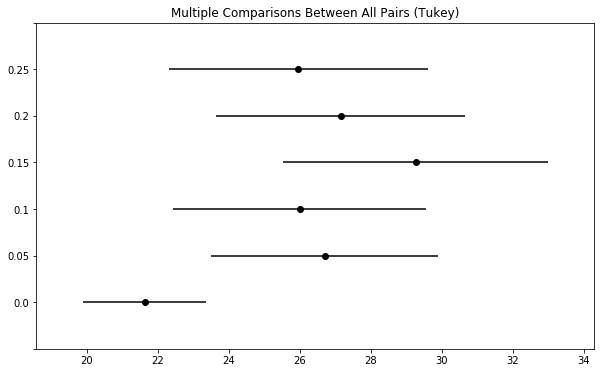

In [23]:
q2C = q2.loc[q2['Country'] != 'UK']
q2C = q2C.reset_index(drop=True)
for idx, x in enumerate(q2C.Discount):
    if 0.00 < x <= 0.06:
        q2C.loc[idx, 'Discount'] = 0.05
    else:
        pass

tukey_results = pairwise_tukeyhsd(q2C['Quantity'], q2C['Discount'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

### Does the level(s) of discount offered by UK employees have a statistically significant effect on the quantity ordered? If so, at what level(s) of discount?

$H_0$ (for each level): there is no significant difference in quantity ordered due to that specific discount level

$H_\alpha$ (for each level): there is a significant difference in order quantity due to that specific discount level

In [24]:
q2UK = q2B.loc[q2B['Country'] != 'USA']
q2UK = q2UK.reset_index(drop=True)
q2UK.head()

,Quantity,Discount,Country,Discountlow,Discount10,Discount15,Discount20,Discount25,Count
0,15,0.15,UK,False,False,True,False,False,69
1,21,0.15,UK,False,False,True,False,False,20
2,60,0.25,UK,False,False,False,False,True,28
3,60,0.25,UK,False,False,False,False,True,28
4,36,0.25,UK,False,False,False,False,True,12


In [25]:
f = 'Quantity ~ C(Discountlow) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'
lm = ols(f, q2UK).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(Discountlow),759.507299,1.0,2.083938,0.150128
C(Discount10),7.170052,1.0,0.019673,0.888568
C(Discount15),1096.591752,1.0,3.008831,0.084065
C(Discount20),831.541590,1.0,2.281586,0.132201
C(Discount25),6964.440564,1.0,19.109051,0.000018
Residual,89656.592439,246.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
0.0,0.05,5.474,-2.5343,13.4823,False
0.0,0.1,1.8194,-5.9004,9.5393,False
0.0,0.15,4.6609,-3.4746,12.7965,False
0.0,0.2,4.6861,-4.045,13.4171,False
0.0,0.25,11.6064,2.9586,20.2542,True
0.05,0.1,-3.6545,-13.8696,6.5605,False
0.05,0.15,-0.813,-11.3458,9.7197,False
0.05,0.2,-0.7879,-11.7871,10.2113,False
0.05,0.25,6.1324,-4.8009,17.0657,False
0.1,0.15,2.8415,-7.4736,13.1567,False


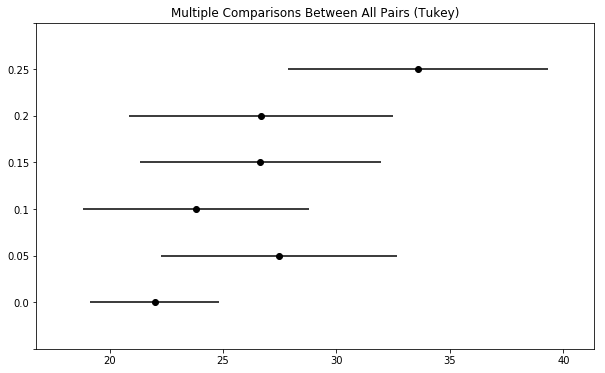

In [26]:
q2D = q2.loc[q2['Country'] != 'USA']
q2D = q2D.reset_index(drop=True)
for idx, x in enumerate(q2D.Discount):
    if 0.00 < x <= 0.06:
        q2D.loc[idx, 'Discount'] = 0.05
    else:
        pass

tukey_results = pairwise_tukeyhsd(q2D['Quantity'], q2D['Discount'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

## Question 3

### This question will circulate around the signficance of the age and title of the employee processing the order

### Does the age of the employee have a statistically significant effect on number of orders processed?

$H_0$: there is no significant difference in total sum of orders processed due employee age

$H_\alpha$: there is a significant difference in total sum of orders processed due to employee age

In [27]:
x = """SELECT o.Id, e.BirthDate, e.Title
       FROM [Order] AS o
       JOIN Employee AS e ON o.EmployeeId = e.Id
       ;"""
q3 = pd.read_sql_query(x, conn)
q3.sample(10)

,Id,BirthDate,Title
628,10876,1992-05-29,Sales Representative
643,10891,1992-05-29,Sales Representative
254,10502,1984-02-19,"Vice President, Sales"
58,10306,1980-12-08,Sales Representative
228,10476,1990-01-09,Inside Sales Coordinator
640,10888,1980-12-08,Sales Representative
584,10832,1984-02-19,"Vice President, Sales"
655,10903,1995-08-30,Sales Representative
7,10255,1998-01-27,Sales Representative
48,10296,1995-07-02,Sales Representative


In [28]:
for idx, x in enumerate(q3.BirthDate):
    q3.loc[idx, 'BirthDate'] = q3.iloc[idx]['BirthDate'][0:4]
q3.sample(5)

,Id,BirthDate,Title
175,10423,1995,Sales Representative
121,10369,1990,Inside Sales Coordinator
152,10400,1980,Sales Representative
280,10528,1995,Sales Representative
235,10483,1992,Sales Representative


In [29]:
newc = ['1969', '1980', '1984', '1987', '1990', '1992', '1995', '1998']
count = 0
x = []
while count <= (len(newc)-1):
    for idx, ele in enumerate(q3.BirthDate):
        if ele == newc[count]:
            x.append(q3.iloc[idx]['Title'])
            count += 1
            break
        else:
            pass

In [30]:
z = q3.groupby('BirthDate').count()['Id'].reset_index(drop=True)
x = pd.Series(x)
y = pd.Series(q3.groupby('BirthDate').count().index)

In [31]:
dic = { 'Count': z, 'Birthdate': y, 'Title': x} 
q3 = pd.DataFrame(dic)
q3

,Count,Birthdate,Title
0,156,1969,Sales Representative
1,123,1980,Sales Representative
2,96,1984,"Vice President, Sales"
3,42,1987,Sales Manager
4,104,1990,Inside Sales Coordinator
5,72,1992,Sales Representative
6,194,1995,Sales Representative
7,43,1998,Sales Representative


,sum_sq,df,F,PR(>F)
C(Decade),3572.75,2.0,0.549831,0.60836
Residual,16244.75,5.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
60.0,80.0,-69.0,-282.9034,144.9034,False
60.0,90.0,-52.75,-259.8611,154.3611,False
80.0,90.0,16.25,-125.2338,157.7338,False


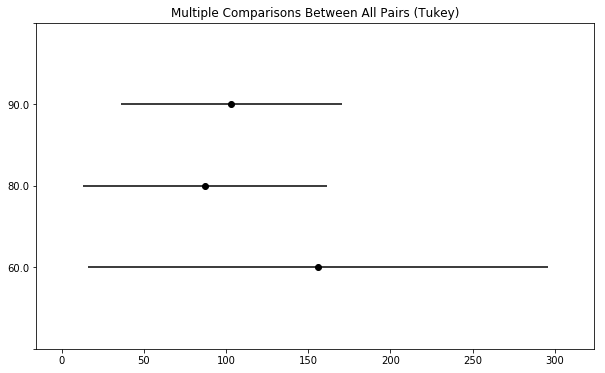

In [32]:
q3.Birthdate = q3.Birthdate.astype(int)
q3.Birthdate[0]
for idx, x in enumerate(q3.Birthdate):
    if x < 1970:
        q3.loc[idx, 'Decade'] = 60
    if 1970 <= x < 1990:
        q3.loc[idx, 'Decade'] = 80
    if 1990 <= x:
        q3.loc[idx, 'Decade'] = 90

f = 'Count ~ C(Decade)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q3['Count'], q3['Decade'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

### Does having manager in your title have a statistically significant effect on number of orders processed?

$H_0$: there is no significant difference in total sum of orders processed due to the employee making order having a managerial position

$H_\alpha$: there is a significant difference in total sum of orders processed due to the employee making order having a managerial position

In [33]:
for idx, x in enumerate(q3.Title):
    if 'Manager' in x:
        q3.loc[idx, 'Manager'] = True
    else:
        q3.loc[idx, 'Manager'] = False

f = 'Count ~ C(Manager)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q3['Count'], q3['Manager'])
display(tukey_results.summary())

,sum_sq,df,F,PR(>F)
C(Manager),4357.785714,1.0,1.691281,0.241147
Residual,15459.714286,6.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-70.5714,-203.3535,62.2106,False


### Does the age of the employee have a statistically significant effect on the quantity of a product in an order?

$H_0$: there is no significant difference in quantity ordered due employee age

$H_\alpha$: there is a significant difference in order quantity ordered due to employee age

In [34]:
x = """SELECT od.Quantity, e.BirthDate, e.Title, c.ContactTitle
       FROM OrderDetail AS od
       JOIN [Order] AS o ON od.OrderId = o.Id
       JOIN Employee AS e ON o.EmployeeId = e.Id
       JOIN Customer AS c ON o.CustomerId = c.Id
       ;"""
q3 = pd.read_sql_query(x, conn)
q3.sample(10)
for idx, x in enumerate(q3.BirthDate):
    q3.loc[idx, 'BirthDate'] = q3.iloc[idx]['BirthDate'][0:4]
q3.sample(5)

,Quantity,BirthDate,Title,ContactTitle
502,6,1990,Inside Sales Coordinator,Sales Associate
2056,1,1980,Sales Representative,Assistant Sales Representative
114,10,1990,Inside Sales Coordinator,Sales Associate
543,30,1992,Sales Representative,Accounting Manager
496,24,1969,Sales Representative,Sales Representative


,sum_sq,df,F,PR(>F)
C(BirthDate),4290.687970,7.0,1.67501,0.110648
Residual,757498.450144,2070.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1969,1980,-0.7209,-4.9793,3.5376,False
1969,1984,1.7812,-2.959,6.5214,False
1969,1987,1.9355,-4.2342,8.1053,False
1969,1990,-0.8272,-5.5004,3.846,False
1969,1992,4.4196,-1.1223,9.9615,False
1969,1995,-0.185,-4.1046,3.7345,False
1969,1998,1.4729,-4.8309,7.7766,False
1980,1984,2.5021,-2.4062,7.4104,False
1980,1987,2.6564,-3.6434,8.9562,False
1980,1990,-0.1063,-4.95,4.7373,False


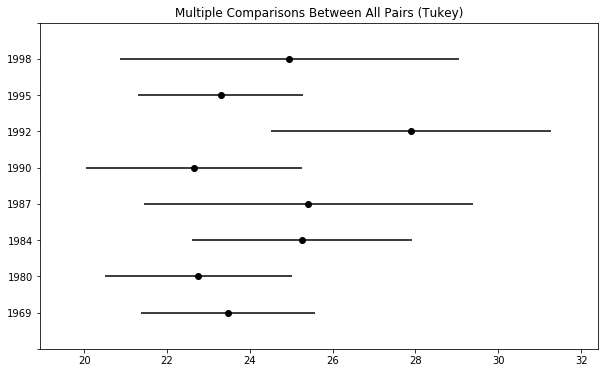

In [35]:
f = 'Quantity ~ C(BirthDate)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q3['Quantity'], q3['BirthDate'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

### Does having manager in your title have a statistically significant effect on quantity ordered?

$H_0$: there is no significant difference in quantity ordered due to the employee making order having a managerial position

$H_\alpha$: there is a significant difference in order quantity ordered due to the employee making order having a managerial position

In [36]:
for idx, x in enumerate(q3.ContactTitle):
    if 'Manager' in x:
        q3.loc[idx, 'Manager'] = True
    else:
        q3.loc[idx, 'Manager'] = False

f = 'Quantity ~ C(Manager)'
lm = ols(f, q3).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q3['Quantity'], q3['ContactTitle'])
display(tukey_results.summary())

,sum_sq,df,F,PR(>F)
C(Manager),9585.082472,1.0,26.453768,2.952829e-07
Residual,752204.055641,2076.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
Accounting Manager,Assistant Sales Agent,-5.3061,-15.3436,4.7315,False
Accounting Manager,Assistant Sales Representative,-9.4086,-17.5231,-1.2941,True
Accounting Manager,Marketing Assistant,-8.1695,-15.982,-0.357,True
Accounting Manager,Marketing Manager,-8.601,-14.3291,-2.8728,True
Accounting Manager,Order Administrator,-10.1617,-18.7423,-1.581,True
Accounting Manager,Owner,-7.2457,-12.1544,-2.337,True
Accounting Manager,Owner/Marketing Assistant,-20.1816,-35.548,-4.8151,True
Accounting Manager,Sales Agent,-9.455,-17.4345,-1.4755,True
Accounting Manager,Sales Associate,-7.0812,-13.0834,-1.079,True
Accounting Manager,Sales Manager,-1.1068,-5.9407,3.7272,False


## Question 4
### For each category type of product, does the season in which the order was placed have a statistically significant effect on the quantity of a product in an order?

$H_0$: there is no significant difference in quantity ordered due to season in which order was placed

$H_\alpha$: there is a significant difference in order quantity ordered due to season in which order was placed

In [37]:
x = """SELECT [Order].OrderDate, ca.CategoryName, od.Quantity
       FROM OrderDetail AS od
       JOIN [Order] ON od.OrderId = [Order].Id
       JOIN Product AS p ON od.ProductId = p.Id
       JOIN Customer AS c ON c.Id = [Order].CustomerId
       JOIN Category AS ca ON p.CategoryId = ca.Id
       ;"""
q4 = pd.read_sql_query(x, conn)
q4.head()

,OrderDate,CategoryName,Quantity
0,2012-07-04,Dairy Products,12
1,2012-07-04,Grains/Cereals,10
2,2012-07-04,Dairy Products,5
3,2012-07-05,Produce,9
4,2012-07-05,Produce,40


In [38]:
q4.OrderDate = pd.to_datetime(q4.OrderDate)
#create dictionary for seasons
season_names = {1: 'Winter', 2 : 'Spring', 3: 'Summer', 4: 'Fall'}
#using modular arithmetic, we split the year into 4 3-month sections and convert each
#month for each row to a number between 1-4
season = q4.OrderDate.apply(lambda dt: (dt.month%12 + 3)//3)
#map to our dictionary
q4['season'] = season.map(season_names)
for idx, x in enumerate(q4.season):
    q4.loc[idx, 'Winter'] = True if x == 'Winter' else False
    q4.loc[idx, 'Spring'] = True if x == 'Spring' else False
    q4.loc[idx, 'Summer'] = True if x == 'Summer' else False
    q4.loc[idx, 'Fall'] = True if x == 'Fall' else False
q4.sample(10)

,OrderDate,CategoryName,Quantity,season,Winter,Spring,Summer,Fall
1064,2013-09-12,Condiments,10,Fall,False,False,False,True
1648,2014-02-24,Confections,20,Winter,True,False,False,False
905,2013-07-16,Seafood,30,Summer,False,False,True,False
72,2012-08-07,Beverages,12,Summer,False,False,True,False
584,2013-03-13,Dairy Products,12,Spring,False,True,False,False
1855,2014-04-02,Grains/Cereals,40,Spring,False,True,False,False
1363,2013-12-22,Beverages,40,Winter,True,False,False,False
1255,2013-11-18,Seafood,24,Fall,False,False,False,True
1662,2014-02-26,Beverages,10,Winter,True,False,False,False
1671,2014-02-27,Dairy Products,6,Winter,True,False,False,False


In [39]:
z = q4['Quantity'].value_counts()
z1 = z.to_dict()
q4['Count'] = q4['Quantity'].map(z1)
for idx, x in enumerate(q4.Count):
    if x < 4:
        if q4.Quantity[idx] == 1:
            pass
        else:
            q4.drop(index = idx, axis = 0, inplace=True)
q4 = q4.reset_index(drop=True)
q4.sample(10)

,OrderDate,CategoryName,Quantity,season,Winter,Spring,Summer,Fall,Count
1741,2014-03-16,Produce,2,Spring,False,True,False,False,50
1338,2013-12-18,Seafood,30,Winter,True,False,False,False,185
1427,2014-01-08,Confections,3,Winter,True,False,False,False,45
1256,2013-11-20,Grains/Cereals,15,Fall,False,False,False,True,159
1365,2013-12-25,Condiments,10,Winter,True,False,False,False,175
1268,2013-11-25,Seafood,4,Fall,False,False,False,True,54
1691,2014-03-06,Confections,30,Spring,False,True,False,False,185
204,2012-10-10,Grains/Cereals,16,Fall,False,False,False,True,35
1701,2014-03-09,Seafood,30,Spring,False,True,False,False,185
1631,2014-02-24,Beverages,20,Winter,True,False,False,False,247


In [40]:
newc = ['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']
for x in newc:
    print(x)
    q4A = q4.loc[q4['CategoryName'] == x]
    q4A = q4A.reset_index(drop=True)
    for y in q4A.columns[4:8]:
        print(y + ':')
        f = 'Quantity ~ C(' + y + ')'
        lm = ols(f, q4A).fit()
        table = sm.stats.anova_lm(lm, typ=1)
        display(table)
        print()
        tukey_results = pairwise_tukeyhsd(q4A['Quantity'], q4A[y])
        display(tukey_results.summary())
        print()

print('Total')
for y in q4.columns[4:8]:
    print(y + ':')
    f = 'Quantity ~ C(' + y + ')'
    lm = ols(f, q4).fit()
    table = sm.stats.anova_lm(lm, typ=1)
    display(table)
    print()
    tukey_results = pairwise_tukeyhsd(q4['Quantity'], q4[y])
    display(tukey_results.summary())
    print()

Dairy Products
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,1704.421018,1704.421018,5.330455,0.021546
Residual,345.0,110314.270625,319.751509,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,4.9869,0.7385,9.2352,True



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,1102.695478,1102.695478,3.429892,0.06488
Residual,345.0,110915.996165,321.495641,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-3.8502,-7.9392,0.2388,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,3.894425,3.894425,0.011995,0.912854
Residual,345.0,112014.797218,324.680572,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.2715,-5.1478,4.6047,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,27.358309,27.358309,0.08428,0.771754
Residual,345.0,111991.333333,324.612560,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.6667,-5.1834,3.85,False



Grains/Cereals
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,230.122440,230.122440,0.856388,0.355951
Residual,186.0,49980.579687,268.712794,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.3734,-2.6863,7.4331,False



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,358.550990,358.550990,1.337765,0.248912
Residual,186.0,49852.151138,268.022318,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-3.1061,-8.4039,2.1918,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,19.067328,19.067328,0.07066,0.790673
Residual,186.0,50191.634800,269.847499,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.8371,-5.3758,7.0501,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,0.548087,0.548087,0.00203,0.964108
Residual,186.0,50210.154040,269.947065,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.1275,-5.7109,5.4558,False



Produce
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,82.801055,82.801055,0.236016,0.627929
Residual,128.0,44906.091253,350.828838,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.7687,-8.9723,5.4349,False



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,110.989869,110.989869,0.316563,0.574664
Residual,128.0,44877.902439,350.608613,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,1.9146,-4.8187,8.6479,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,27.275079,27.275079,0.077649,0.780959
Residual,128.0,44961.617229,351.262635,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.2003,-9.7236,7.3229,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,7.323284,7.323284,0.020839,0.885445
Residual,128.0,44981.569024,351.418508,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.633,-8.0433,9.3093,False



Seafood
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,151.710950,151.710950,0.475746,0.490873
Residual,309.0,98537.118632,318.890352,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,1.579,-2.9255,6.0835,False



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,1686.043734,1686.043734,5.370851,0.021129
Residual,309.0,97002.785848,313.924873,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-4.9473,-9.1477,-0.7468,True



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,326.441048,326.441048,1.025496,0.312011
Residual,309.0,98362.388534,318.324882,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.8121,-2.652,8.2762,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,288.157634,288.157634,0.904879,0.34222
Residual,309.0,98400.671948,318.448777,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.24,-2.3935,6.8736,False



Condiments
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,1862.551862,1862.551862,4.970244,0.026877
Residual,204.0,76447.064643,374.740513,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,6.9669,0.8054,13.1283,True



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,1568.734782,1568.734782,4.170162,0.042429
Residual,204.0,76740.881723,376.180793,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-5.8263,-11.4516,-0.201,True



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,20.482106,20.482106,0.053371,0.81753
Residual,204.0,78289.134398,383.770267,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.813,-7.7513,6.1254,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,20.247577,20.247577,0.052759,0.818559
Residual,204.0,78289.368928,383.771416,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.7471,-5.6658,7.16,False



Confections
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,3.787730,3.787730,0.012578,0.910776
Residual,315.0,94861.114478,301.146395,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.2306,-3.8156,4.2769,False



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,702.755681,702.755681,2.350924,0.126212
Residual,315.0,94162.146527,298.927449,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,3.3366,-0.945,7.6183,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,122.602129,122.602129,0.407629,0.52364
Residual,315.0,94742.300079,300.769207,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.75,-7.1431,3.643,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,430.422208,430.422208,1.435736,0.231731
Residual,315.0,94434.480000,299.792000,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-2.7418,-7.244,1.7603,False



Beverages
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,117.659050,117.659050,0.360372,0.548655
Residual,382.0,124720.275846,326.492869,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.2244,-5.2345,2.7858,False



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,829.403813,829.403813,2.554923,0.110778
Residual,382.0,124008.531082,324.629663,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,3.1238,-0.7188,6.9663,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,279.794939,279.794939,0.858087,0.35486
Residual,382.0,124558.139957,326.068429,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-2.187,-6.8289,2.455,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,28.504734,28.504734,0.087243,0.767872
Residual,382.0,124809.430162,326.726257,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.6872,-5.2621,3.8876,False



Meat/Poultry
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,899.929860,899.929860,1.810575,0.180308
Residual,163.0,81017.682261,497.040995,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,4.9113,-2.296,12.1186,False



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,767.709101,767.709101,1.542042,0.216098
Residual,163.0,81149.903020,497.852166,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-4.9518,-12.8259,2.9223,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,206.546266,206.546266,0.412025,0.521845
Residual,163.0,81711.065855,501.294883,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-3.0708,-12.5175,6.3758,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,50.349121,50.349121,0.100247,0.751939
Residual,163.0,81867.263000,502.253147,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,1.289,-6.75,9.328,False



Total
Winter:


,df,sum_sq,mean_sq,F,PR(>F)
C(Winter),1.0,1722.643972,1722.643972,5.143631,0.023436
Residual,2046.0,685222.058665,334.908142,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,2.0151,0.2726,3.7576,True



Spring:


,df,sum_sq,mean_sq,F,PR(>F)
C(Spring),1.0,954.753535,954.753535,2.847601,0.091663
Residual,2046.0,685989.949102,335.283455,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-1.4756,-3.1905,0.2393,False



Summer:


,df,sum_sq,mean_sq,F,PR(>F)
C(Summer),1.0,117.135902,117.135902,0.348938,0.55478
Residual,2046.0,686827.566734,335.692848,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.6332,-2.7354,1.469,False



Fall:


,df,sum_sq,mean_sq,F,PR(>F)
C(Fall),1.0,1.463615,1.463615,0.004359,0.947365
Residual,2046.0,686943.239022,335.749384,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,-0.0641,-1.9683,1.8401,False


In [41]:
tukey_results = pairwise_tukeyhsd(q4['Quantity'], q4['season'])
display(tukey_results.summary())

group1,group2,meandiff,lower,upper,reject
Fall,Spring,-0.9676,-3.8503,1.9151,False
Fall,Summer,-0.4743,-3.8063,2.8577,False
Fall,Winter,1.4745,-1.4442,4.3932,False
Spring,Summer,0.4933,-2.6307,3.6172,False
Spring,Winter,2.4421,-0.2366,5.1208,False
Summer,Winter,1.9488,-1.2084,5.106,False


## Question 5
### Does shipping company used have a statistically significant effect on the freight cost of shipping?

$H_0$: there is no significant difference in freight cost due to shipper

$H_\alpha$: there is a significant difference in freight cost due to shipper

In [42]:
x = """SELECT Id, ShipVia, Freight
       FROM [Order]
       ;"""
q5 = pd.read_sql_query(x, conn)
q5.tail()

,Id,ShipVia,Freight
825,11073,2,24.95
826,11074,2,18.44
827,11075,2,6.19
828,11076,2,38.28
829,11077,2,8.53


In [43]:
f = 'Freight ~ C(ShipVia)'
lm = ols(f, q5).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)

,sum_sq,df,F,PR(>F)
C(ShipVia),6.788200e+04,2.0,2.49781,0.082885
Residual,1.123753e+07,827.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1,2,21.6393,-1.3965,44.6752,False
1,3,15.4399,-8.9452,39.825,False
2,3,-6.1994,-29.0811,16.6823,False


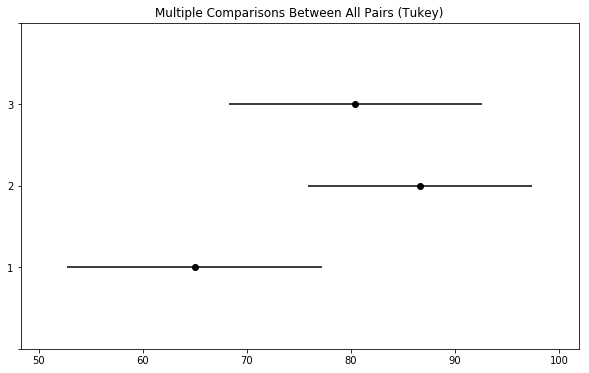

In [44]:
tukey_results = pairwise_tukeyhsd(q5['Freight'], q5['ShipVia'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

## Question 6
### We will explore questions circulating around processing time (days between order being put in and order being shipped).

### Does category of product have a statistically signficiant effect on processing time? If so, which ones?

$H_0$: there is no significant difference in processing time due to category of product

$H_\alpha$: there is a significant difference in order quantity due to category of product

In [45]:
x = """SELECT o.Id, od.Quantity, od.Discount, o.OrderDate, o.ShippedDate, p.CategoryId, ca.CategoryName
       FROM OrderDetail od
       JOIN [Order] AS o ON od.OrderId = o.Id
       JOIN Product AS p ON od.ProductId = p.Id
       JOIN Category AS ca ON p.CategoryId = ca.Id
       WHERE o.ShippedDate IS NOT NULL
       ;"""
q6 = pd.read_sql_query(x, conn)
q6.tail()

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName
2077,11066,3,0.0,2014-05-01,2014-05-04,3,Confections
2078,11066,42,0.0,2014-05-01,2014-05-04,3,Confections
2079,11066,35,0.0,2014-05-01,2014-05-04,1,Beverages
2080,11067,9,0.0,2014-05-04,2014-05-06,8,Seafood
2081,11069,20,0.0,2014-05-04,2014-05-06,1,Beverages


In [46]:
from datetime import date
q6.OrderDate = pd.to_datetime(q6.OrderDate)
q6.ShippedDate = pd.to_datetime(q6.ShippedDate)
for idx, x in enumerate(q6.OrderDate):
    q6.loc[idx, 'Daysbeforeship'] = (q6.iloc[idx]['ShippedDate'] - q6.iloc[idx]['OrderDate']).days
q6.head()

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName,Daysbeforeship
0,10248,12,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0
1,10248,10,0.0,2012-07-04,2012-07-16,5,Grains/Cereals,12.0
2,10248,5,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0
3,10249,9,0.0,2012-07-05,2012-07-10,7,Produce,5.0
4,10249,40,0.0,2012-07-05,2012-07-10,7,Produce,5.0


In [47]:
z = q6['Quantity'].value_counts()
z1 = z.to_dict()
q6['Count'] = q6['Quantity'].map(z1)
for idx, x in enumerate(q6.Count):
    if x < 4:
        if q6.Quantity[idx] == 1:
            pass
        else:
            q6.drop(index = idx, axis = 0, inplace=True)
q6 = q6.reset_index(drop=True)
q6.head()

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName,Daysbeforeship,Count
0,10248,12,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0,90
1,10248,10,0.0,2012-07-04,2012-07-16,5,Grains/Cereals,12.0,174
2,10248,5,0.0,2012-07-04,2012-07-16,4,Dairy Products,12.0,67
3,10249,9,0.0,2012-07-05,2012-07-10,7,Produce,5.0,30
4,10249,40,0.0,2012-07-05,2012-07-10,7,Produce,5.0,111


,sum_sq,df,F,PR(>F)
C(CategoryId),231.434185,7.0,0.737923,0.639805
Residual,91534.919789,2043.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1,2,0.0245,-1.7386,1.7876,False
1,3,-0.0315,-1.5683,1.5053,False
1,4,-0.4093,-1.9088,1.0903,False
1,5,-0.0952,-1.8973,1.7069,False
1,6,-0.1411,-2.0283,1.7461,False
1,7,-1.155,-3.2469,0.937,False
1,8,-0.6881,-2.2383,0.862,False
2,3,-0.056,-1.8772,1.7651,False
2,4,-0.4338,-2.2236,1.356,False
2,5,-0.1197,-2.1697,1.9303,False


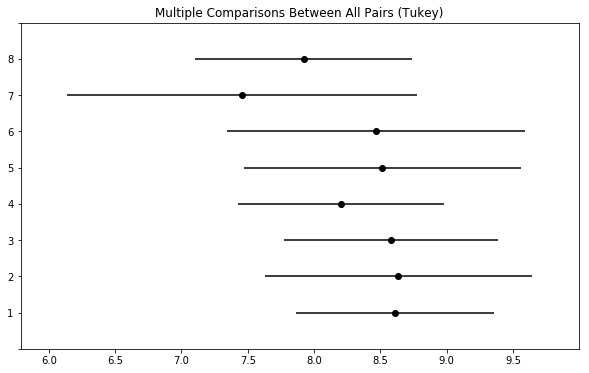

In [48]:
f = 'Daysbeforeship ~ C(CategoryId)'
lm = ols(f, q6).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q6['Daysbeforeship'], q6['CategoryId'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

### Does having a discount on the order have a statistically significant effect on processing time?

$H_0$: there is no significant difference in processing due to discount being applied

$H_\alpha$: there is a significant difference in processing due to discount being applied

In [49]:
for ind, x in enumerate(q6.Discount):
    if x == 0:
        q6.loc[ind, 'is_Discount'] = False
    else:
        q6.loc[ind, 'is_Discount'] = True
display(q6.sample(5))

f = 'Daysbeforeship ~ C(is_Discount)'
lm = ols(f, q6).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q6['Daysbeforeship'], q6['is_Discount'])
display(tukey_results.summary())

,Id,Quantity,Discount,OrderDate,ShippedDate,CategoryId,CategoryName,Daysbeforeship,Count,is_Discount
1337,10761,35,0.25,2013-12-02,2013-12-08,3,Confections,6.0,70,True
1324,10756,6,0.20,2013-11-27,2013-12-02,3,Confections,5.0,87,True
572,10465,30,0.10,2013-03-05,2013-03-14,8,Seafood,9.0,191,True
359,10386,10,0.00,2012-12-18,2012-12-25,1,Beverages,7.0,174,False
844,10567,3,0.00,2013-06-12,2013-06-17,7,Produce,5.0,42,False


,sum_sq,df,F,PR(>F)
C(is_Discount),34.637258,1.0,0.773688,0.379182
Residual,91731.716715,2049.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
False,True,0.2674,-0.3287,0.8635,False


### Does size of order have a statistically signficant effect on processing time?
$H_0$: there is no significant difference in processing time due to quantity ordered

$H_\alpha$: there is a significant difference in processing time due to quantity ordered

,sum_sq,df,F,PR(>F)
C(CategoryQ),126.253107,6.0,0.469338,0.831459
Residual,91640.100867,2044.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1.0,2.0,-0.0891,-1.2381,1.0599,False
1.0,3.0,0.4628,-0.8256,1.7513,False
1.0,4.0,0.2047,-1.4021,1.8116,False
1.0,5.0,-0.2872,-2.2456,1.6712,False
1.0,6.0,-0.568,-3.1376,2.0016,False
1.0,7.0,-0.0199,-2.5389,2.4992,False
2.0,3.0,0.5519,-0.716,1.8199,False
2.0,4.0,0.2938,-1.2966,1.8843,False
2.0,5.0,-0.1981,-2.1431,1.7469,False
2.0,6.0,-0.4789,-3.0383,2.0805,False


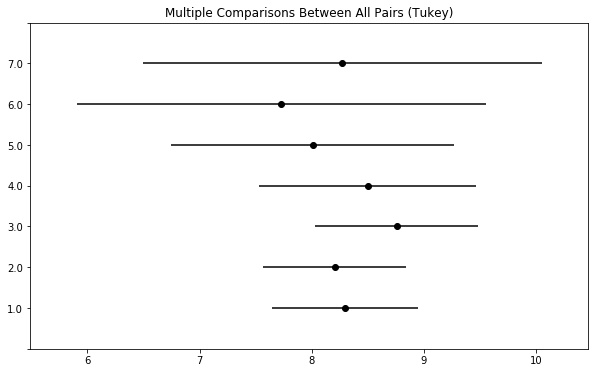

In [50]:
for idx, x in enumerate(q6.Quantity):
    if 0 < x <= 10:
        q6.loc[idx, 'CategoryQ'] = 1
    elif 10 < x <= 20:
        q6.loc[idx, 'CategoryQ'] = 2
    elif 20 < x <= 30:
        q6.loc[idx, 'CategoryQ'] = 3
    elif 30 < x <= 40:
        q6.loc[idx, 'CategoryQ'] = 4
    elif 40 < x <= 50:
        q6.loc[idx, 'CategoryQ'] = 5
    elif 50 < x <= 60:
        q6.loc[idx, 'CategoryQ'] = 6
    elif 60 < x :
        q6.loc[idx, 'CategoryQ'] = 7
f = 'Daysbeforeship ~ C(CategoryQ)'
lm = ols(f, q6).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q6['Daysbeforeship'], q6['CategoryQ'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

### Does shipping company have a statistically significant effect on processing time?

$H_0$: there is no significant difference in processing time due to shipper

$H_\alpha$: there is a significant difference in processing time due to shipper

,Daysbeforeship
ShipVia,
1,8.571429
2,9.234921
3,7.473896


,sum_sq,df,F,PR(>F)
C(ShipVia),433.501581,2.0,4.676819,0.009563
Residual,37354.696194,806.0,NaN,NaN


group1,group2,meandiff,lower,upper,reject
1,2,0.6635,-0.6982,2.0252,False
1,3,-1.0975,-2.536,0.3409,False
2,3,-1.761,-3.1165,-0.4055,True


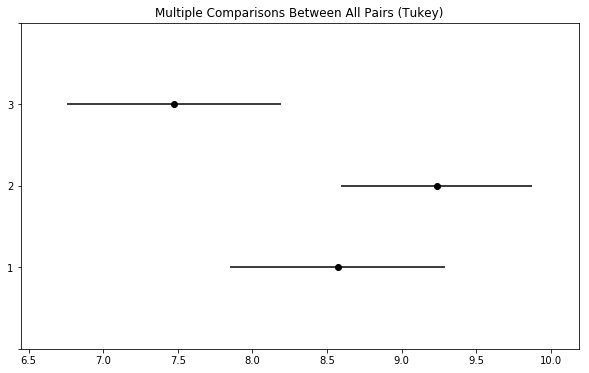

In [51]:
x = """SELECT Id, OrderDate, ShippedDate, ShipVia
       FROM [Order]
       WHERE ShippedDate IS NOT NULL
       ;"""
q6A = pd.read_sql_query(x, conn)
q6A.tail()

from datetime import date
q6A.OrderDate = pd.to_datetime(q6A.OrderDate)
q6A.ShippedDate = pd.to_datetime(q6A.ShippedDate)
for idx, x in enumerate(q6A.OrderDate):
    q6A.loc[idx, 'Daysbeforeship'] = (q6A.iloc[idx]['ShippedDate'] - q6A.iloc[idx]['OrderDate']).days

q6B = q6A.drop_duplicates(subset=None, keep='first')
q6B.drop(['Id'], axis = 1, inplace = True)
q6B = q6B.reset_index(drop=True)
display(q6B.groupby('ShipVia').mean())

f = 'Daysbeforeship ~ C(ShipVia)'
lm = ols(f, q6B).fit()
table = sm.stats.anova_lm(lm, typ=2)
display(table)
tukey_results = pairwise_tukeyhsd(q6B['Daysbeforeship'], q6B['ShipVia'])
display(tukey_results.summary())
tukey_results.plot_simultaneous().show()

In [52]:
x = """SELECT Id, CompanyName
       FROM Shipper
       ;"""
q7 = pd.read_sql_query(x, conn)
q7.drop_duplicates(subset=None, keep='first')

,Id,CompanyName
0,1,Speedy Express
1,2,United Package
2,3,Federal Shipping
